# Calculating event rates for GRB from BATSE

### Author: Hannah Gulick

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import lmfit

### Reading in BATSE data

In [11]:
BATSE_data = open('BATSE.csv').read().split(',')

This section will need to be edited for your specific catalog:

In [23]:
#selecting the event duration
t90 = BATSE_data[8::6]

#the BATSE catalog didn't split well in 'open' so I had to add flux values in a for loop
phtflux = [] #units of photons/cm2/s
for i in BATSE_data[12::6]:
    split_data = i.split('\n')
    phtflux.append(split_data[0])
    
#again, catalog did not split well so removing '' entries from event durations
for i in range(len(t90)):
    if t90[i] == '':
        t90[i] = -1

In [13]:
#making entries in the time and flux arrays into floats
t90 = np.array(t90).astype(float)
phtflux = np.array(phtflux).astype(float)

In [14]:
#printing the number of data entries to cross check with how many i expected in the catalog
print('There are %s GRB in the BATSE catalog.' %(len(t90)))

There are 2145 GRB in the BATSE catalog.


#### Plotting GRB disribution

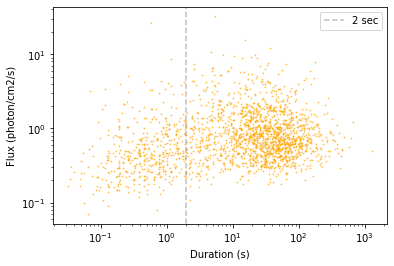

In [15]:
plt.scatter(t90, phtflux, s = 1, c = 'orange', alpha = 0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Flux (photon/cm2/s)')
#adding the boundary between long and short GRB at 2 seconds (this doesn't exist for magnetar)
plt.axvline(2, linestyle = 'dashed', color = 'grey', alpha = 0.5, label = '2 sec')
plt.legend()
plt.show()

### Finding short and long GRBs, separately

This is not needed for magnetars

In [16]:
#short GRB
sGRB_index = []
for i in range(len(t90)):
    if t90[i] <= 2:
        sGRB_index.append(i)
        
sGRB_flux = phtflux[sGRB_index]
sGRB_duration = t90[sGRB_index]

In [17]:
print('The number of short GRB is:', len(sGRB_index))

The number of short GRB is: 616


In [19]:
#long GRB
lGRB_index = []
for i in range(len(t90)):
    if t90[i] > 2:
        lGRB_index.append(i)
        
lGRB_flux = phtflux[lGRB_index]
lGRB_duration = t90[lGRB_index]

In [20]:
print('The number of long GRB is:', len(lGRB_index))

The number of long GRB is: 1529


In [31]:
print('Of the full BATSE catalog, %.2f are short GRB' %(len(sGRB_index)/(len(t90))*100))

Of the full BATSE catalog, 28.72 are short GRB


### Calculating the counts/s for short and long GRB

The BATSE flux data is in units of photons/cm^2/s. We want to calculate the flux in terms of photons/s, therefore we need to multiply the flux in (photons/cm^2/s) by the collecting area of our instrument. In gamma-ray instrumentation, this is often called the 'effective area'. You will need to find the effective are of your instrument for ALL detectors included in the flux count (i.e. some instruments have more than one detector).

In [24]:
#change this to reflect the effective area of your instrument. good to add your source too
area = 1100 #cm2 for BATSE from https://www.researchgate.net/publication/51889049_The_Second_Swift_BAT_Gamma-Ray_Burst_Catalog

In [67]:
#calculating total flux in terms of counts
counts_p_s_sGRB = np.array(sGRB_flux*area) #units: photons/s
counts_p_s_lGRB = np.array(lGRB_flux*area) #units: photons/s

### Making histograms of total counts and fitting

We want to make a histogram to show the number of GRB with a given total count value. This shows us how many GRB will give XXX amount of photons.

In [122]:
def lmfit_exp(A, x, tau):
    return A*np.exp(-x/tau)

def plot_fit_hist(data, bin_num, x_label):
    
    '''
    Inputs:
        data = data array (i.e. fluence or photon/s)
        bin_num = number of bins
        to highlight the lower fluence end of the histrogram.
        x_label = label for x-axis (i.e. fluence (with UNITS), or photons/s)
    '''
    
    #making a histogram
    counts,bin_edges = np.histogram(data, bin_num, density = False)
    #finding center of bins for plotting
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    #fitting an exponential to the histogram
    mod = lmfit.models.ExponentialModel()
    pars = mod.guess(counts, x=bin_centres)
    out = mod.fit(counts, pars, x=bin_centres)
    #print(out.fit_report())
    
    
    #reading out results
    results = out.fit_report().split()
    print(results)
    amp = float(results[42])
    amp_err = float(results[44])
    decay = float(results[50])
    decay_err = float(results[52])
    
    ### PLOTTING ####

    x_new = np.linspace(min(bin_centres), max(bin_centres), 500)
    # histogram on linear scale
    plt.figure(figsize = (11,8))
    plt.subplot(211)
    hist, bins, _ = plt.hist(data, density = False, bins=bin_num, fc = 'None', ec = 'black')
    plt.plot(x_new, lmfit_exp(amp, x_new, decay), color = 'red', linestyle = 'dashed', label="Exponential Fit")
    plt.ylabel('Number of GRB', fontsize = 19)
    #plotting a vertical line indicating what our estimated background rate is for BTO.
    #NOTE not a great direct comparison bc BATSE, GBM, etc. will have their own, different background rates
    plt.axvline(60.9, linestyle = 'dotted', color = 'grey', alpha = 0.9, label = 'Background Rate: 60.9 count/s')
    plt.xlabel(x_label, fontsize = 19)
    plt.xticks(fontsize = 17)
    plt.yticks(fontsize = 17)
    plt.legend(fontsize = 15)
    plt.show()

    print('The exponential fit parameters are: amplitude = %.2f +/- %.4f, decay = %.2f +/- %.2f' %(amp, amp_err, decay, decay_err))

    return bins, hist
    
    

##### short GRB

['[[Model]]', 'Model(exponential)', '[[Fit', 'Statistics]]', '#', 'fitting', 'method', '=', 'leastsq', '#', 'function', 'evals', '=', '67', '#', 'data', 'points', '=', '100', '#', 'variables', '=', '2', 'chi-square', '=', '4976.15505', 'reduced', 'chi-square', '=', '50.7770923', 'Akaike', 'info', 'crit', '=', '394.724261', 'Bayesian', 'info', 'crit', '=', '399.934601', '[[Variables]]', 'amplitude:', '272.326380', '+/-', '11.6630585', '(4.28%)', '(init', '=', '0.0008926223)', 'decay:', '733.305654', '+/-', '39.3961272', '(5.37%)', '(init', '=', '803.8643)', '[[Correlations]]', '(unreported', 'correlations', 'are', '<', '0.100)', 'C(amplitude,', 'decay)', '=', '-0.791']


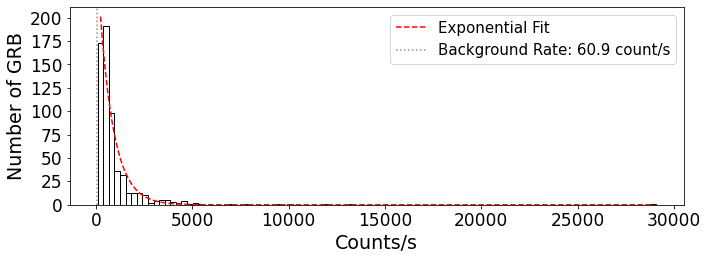

The exponential fit parameters are: amplitude = 272.33 +/- 11.6631, decay = 733.31 +/- 39.40


In [123]:
bins_sGRB, hist_sGRB = plot_fit_hist(counts_p_s_sGRB, 100, 'Counts/s')

##### long GRB

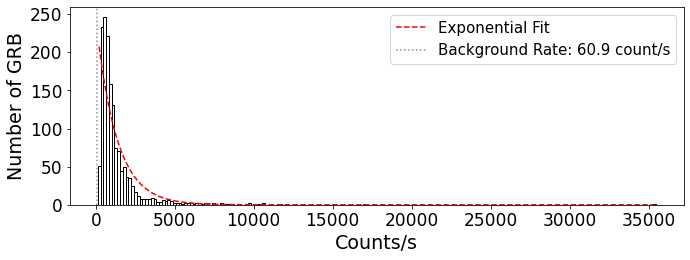

The exponential fit parameters are: amplitude = 244.04 +/- 13.9045, decay = 1295.85 +/- 95.01


In [71]:
bins_lGRB, hist_lGRB = plot_fit_hist(counts_p_s_lGRB, 200, 'Counts/s')

### Determining the number of GRB per 1 day

Now we want to determine how many GRB (short and long) that we would expect in a given time period, i.e. over a day (as calculated in this notebook).

To do this, we need to know the total observing time it took to detect the objects in the catalog.

The BATSE catalog used in MEGAlib (and this analysis) is from https://iopscience.iop.org/article/10.1088/0067-0049/208/2/21. They list the effective exposure time of BATSE as 2390 days. Therefore, it took 2390 days of observing to detect these 2145 GRB.

In [73]:
BATSE_dur = 2390 #days

To determine the number of GRB detected per day, we can just take the total number of GRB in the catalog divided by the effective exposure time.

In [74]:
print('The rate of GRB detections made by BATSE was %.2f GRB/day.' %(len(t90)/BATSE_dur)) #GRB/day

The rate of GRB detections made by BATSE was 0.90 GRB/day.


In [77]:
#calculating how many days between GRB
ave_GRB_interval = (1/(len(t90)/BATSE_dur))
print('Therefore, an average time between GRB is %.3f days' %(ave_GRB_interval))

Therefore, an average time between GRB is 1.114 days


### Determine the rate of GRB with a given counts/s per day

Now, we want to make a histogram of the number of GRB with a given count rate (i.e. 1000 counts/s) happen in a day. We can use this histogram to estimate how frequently we will detect a GRB with an i.e. 1000 counts/s rate.

To do this, we divide our histogram (of the number of GRB with a given count rate) by the total observation time (in days).

You can think of the units of this results as: Number of GRB with a given counts/s per day

In [75]:
lGRB_day = hist_lGRB/(BATSE_dur) #counts/s per day
sGRB_day = hist_sGRB/(BATSE_dur) #counts/s per day

##### Note: I am only doing the calculation for long GRB below

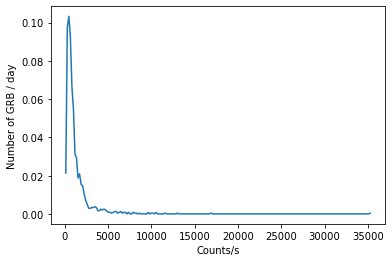

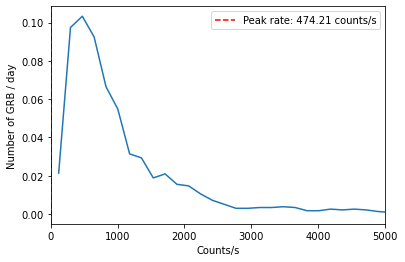

In [92]:
#plotting distribution for long GRB
plt.plot(bins_lGRB[:-1], lGRB_day)
plt.ylabel('Number of GRB / day')
plt.xlabel('Counts/s')
plt.show()

#plotting a zoomed-in version that is easier to see
#plotting distribution
plt.plot(bins_lGRB[:-1], lGRB_day)
plt.ylabel('Number of GRB / day')
plt.xlabel('Counts/s')
plt.xlim(0, 5000)
#finding the event rate that occurs most frequently
plt.axvline(max(lGRB_day), linestyle = 'dashed', color = 'red', label = 'Peak rate: %.2f counts/s' %(bins_lGRB[list(lGRB_day).index(max(lGRB_day))]))
plt.legend()
plt.show()


For example, from the plot above we would expect ~0.1 GRB with a count rate of ~471 counts/s every day.

### Creating a random sample of 'observed' GRB from the above distribution

To find the total estimated data rates from GRB events in a single day, we need to estimate the total number of counts from GRB. We can do this using our distribution above, which tells use exactly the frequency we would expect to have GRB with different count rates.

We can 'simulate' GRB for a given observation time by sampling the x-axis in the plot above, where we weight our choices by the y-axis value. This just means that the higher the y-axis value (i.e. the Number of GRB/day), the more likely it is to get the corresponding x-axis value (i.e. the counts/s). For example, the count/rate of 471 counts/s has the highest rate of GRB/day and is therefore the most likely count rate in our weighted distribution.

To weight our distribution, the sum of the y-axis values must be equal to 1 (this is just a stats thing)---therefore we divide each y-axis value by the sum of the y-axis values:

In [93]:
norm_lGRB_day = np.array(lGRB_day)/sum(lGRB_day)

In [94]:
# cross check that this equals 1:
print(sum(norm_lGRB_day))

1.0000000000000004


Now we randomly select our GRB from the weighted distribution:

In [95]:
#selecting a single GRB event. Each time you execute this cell you will get a different GRB
rand_counts = np.random.choice(bins_lGRB[:-1], p=norm_lGRB_day)
print('Random counts value:', rand_counts)

Random counts value: 650.8149999999999


### Creating a random sample of GRB counts over a few days

Since COSI will not downlink at evenly spaced intervals in time, we need to use the longest possible time between downlinks to determine how much storage we need onboard--this longest time is 1/2 a day. Below, I take a time duration of 5 days.

Using the BATSE use catalog (and the math above), the average interval between GRB (1.114 days) so we expect a sample of ~4 GRB over 5 days.

In [105]:
#the effective exposure time for the calculation
effect_exp = 5 #days
#calculating how many GRB we expect over this exposure time
num_GRB_over_exp_calc = 5/ave_GRB_interval
print('There will be ~%.2f GRB over the effective exposure time of %s days.' %(num_GRB_over_exp_calc, effect_exp))

There will be ~4.49 GRB over the effective exposure time of 5 days.


In [106]:
# we can't have a non-integer number of GRB, so converting value to integer
num_GRB_over_exp = int(num_GRB_over_exp_calc)

Now, create your population! (Note, values will change every time you execute the cell below)

In [107]:
rand_GRB_counts = []
for i in range(num_GRB_over_exp):
    rand_GRB_counts.append(np.random.choice(bins_lGRB[:-1], p=norm_lGRB_day))

This returns GRB with counts/s of:

In [108]:
print('Our %s simulated GRB have rates of: %s counts/s' %(num_GRB_over_exp, rand_GRB_counts))

Our 4 simulated GRB have rates of: [297.605, 1180.6299999999999, 2063.6549999999997, 1887.05] counts/s


### Visualizing our GRB

Below, we make a graph that shows the random GRB at evenly spaced intervals over our observation period. This is just to visualize the different count rates at different times.

In [117]:
#creating x-axis with all zeros
zero_array = np.zeros(100)

In [118]:
##placing the GRB at even intervals across the array
GRB_array_p_s = zero_array
spacing = len(zero_array)/num_GRB_over_exp
for i in range(num_GRB_over_exp):
    GRB_array_p_s[int(i*spacing+spacing/2)] = rand_GRB_counts[i]

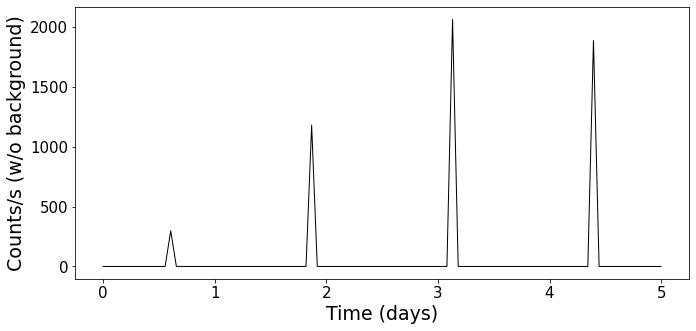

In [120]:
#plotting
time = np.linspace(0, 5, 100)

plt.figure(figsize = (11, 5))
plt.plot(time, GRB_array_p_s, color = 'black', linewidth = 1)
plt.xlabel('Time (days)', fontsize = 19)
plt.ylabel('Counts/s (w/o background)', fontsize = 19)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.yscale('log')
plt.show()

### Final remark:

Okay, so we just did all of these calculations for BATSE (or whichever instrument you are working with). But we really want them for BTO.

We can run simulations with MEGAlib (which we will do) but an easy estimate can be made by scaling the effective are of your instrument with BTO's effective area. Try recreating all these plots but scale them with BTO's effective area to better show the rates we expect with our instrument. Hint 1: BTO's effective area on one long side is 28.88 cm2 and on the top is 14.44 cm2 (these would be separate scalings that just indicate which side of the detector the GRB entered from---you don't need to combine). Hint 2: your numbers should go down.

After this calculation we will calculate totals bits (yay)